In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
import os, sys, gc, warnings, random, datetime
import xgboost as xgb

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train=pd.read_csv('train_final4.csv')
test=pd.read_csv('test_final4.csv')

In [3]:
train.dtypes

TransactionID              int64
isFraud                    int64
TransactionDT              int64
TransactionAmt           float64
ProductCD                float64
card1                    float64
card2                    float64
card3                    float64
card4                    float64
card5                    float64
card6                    float64
addr1                    float64
addr2                    float64
dist1                    float64
dist2                    float64
P_emaildomain              int64
R_emaildomain              int64
C1                       float64
C2                       float64
C3                       float64
C4                       float64
C5                       float64
C6                       float64
C7                       float64
C8                       float64
C9                       float64
C10                      float64
C11                      float64
C12                      float64
C13                      float64
          

In [5]:
obj_cols =train.dtypes
obj_cols[obj_cols=='object']

DT                 object
addr1_card1        object
card2_and_count    object
dtype: object

In [6]:
train['card2_and_count']=pd.to_numeric(train['card2_and_count'],errors='coerce')
train['addr1_card1']=pd.to_numeric(train['addr1_card1'],errors='coerce')

In [7]:
test['card2_and_count']=pd.to_numeric(test['card2_and_count'],errors='coerce')
test['addr1_card1']=pd.to_numeric(test['addr1_card1'],errors='coerce')

In [8]:
split_groups = train['DT_M']

In [9]:
X= train.drop(['TransactionDT','TransactionID','uid','uid2','bank_type',
               'isFraud','DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month'], axis=1)
y = train['isFraud']

In [10]:
X_test = test.drop(['TransactionDT','TransactionID','uid','uid2','bank_type',
                    'isFraud','DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month'], axis=1)

In [11]:
X_test.shape

(506691, 949)

In [13]:
X.shape

(590540, 949)

In [14]:
del train, test
gc.collect()

166

In [16]:
 print(X.shape, X_test.shape)

(590540, 949) (506691, 949)


In [10]:
#fill in -999 for alll missing
#X = X.fillna(-999)
#X_test = X_test.fillna(-999)

In [51]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [53]:
columns = X.columns
splits = folds.split(X, y, groups=split_groups)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importance_df = pd.DataFrame()
dtest = xgb.DMatrix(X_test)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    dtrain = xgb.DMatrix(X[columns].iloc[train_index], y.iloc[train_index])
    dvalid = xgb.DMatrix(X[columns].iloc[valid_index], y.iloc[valid_index])
    y_valid= y.iloc[valid_index]
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'nthread' : 4,
              'eta' : 0.048,
              'max_depth' : 9,
              'missing': -999,
              #'tree_method':'gpu_hist',
              'subsample' : 0.85,
              'colsample_bytree' : 0.85,
              'alpha' : 0.15,
              'lambda' : 0.85,
              'random_state': 99, 
              'silent': True}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 200, verbose_eval=200)
    
    y_pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / NFOLDS
    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(list(model.get_fscore().keys()), columns=['feature'])
    fold_importance_df['importance']=list(model.get_fscore().values())
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del model, dtrain, dvalid, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

[0]	train-auc:0.824146	valid-auc:0.80389
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.992587	valid-auc:0.906722
[400]	train-auc:0.998639	valid-auc:0.910592
[600]	train-auc:0.999804	valid-auc:0.911948
[800]	train-auc:0.999981	valid-auc:0.910912
Stopping. Best iteration:
[624]	train-auc:0.999841	valid-auc:0.912218

Fold 1 | AUC: 0.9122184517349967
[0]	train-auc:0.822189	valid-auc:0.802441
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.99225	valid-auc:0.938164
[400]	train-auc:0.998645	valid-auc:0.940511
Stopping. Best iteration:
[359]	train-auc:0.998067	valid-auc:0.940687

Fold 2 | AUC: 0.940686786273086
[0]	train-auc:0.845361	valid-auc:0.834313
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn

In [57]:
feature_importances = feature_importance_df.groupby('feature').agg({'importance':np.mean}).reset_index()

In [62]:
feature_importances.head()

,feature,importance
0,C1,587.8
1,C10,140.8
2,C10_fq_enc,31.8
3,C11,337.6
4,C11_fq_enc,143.0


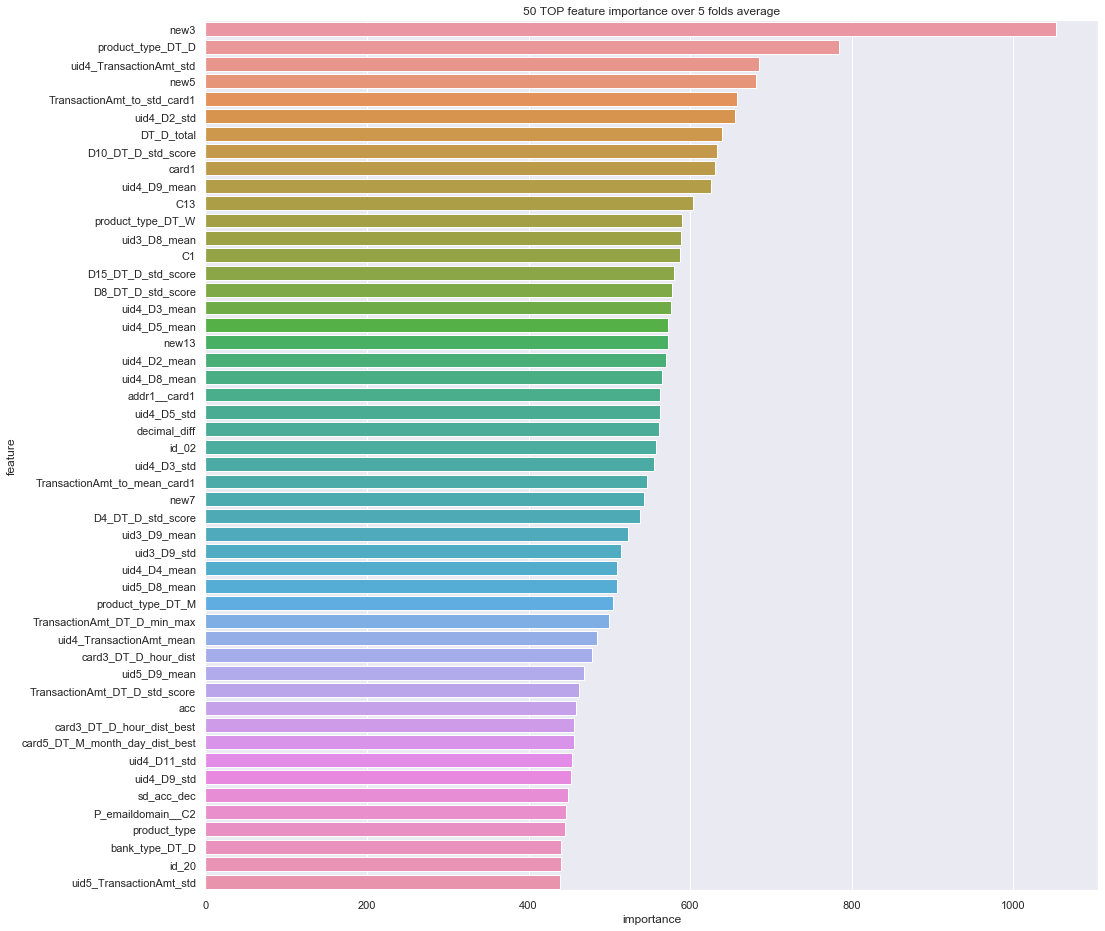

In [60]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='importance', ascending=False).head(50), x='importance', y='feature');
plt.title('50 TOP feature importance over 5 folds average');

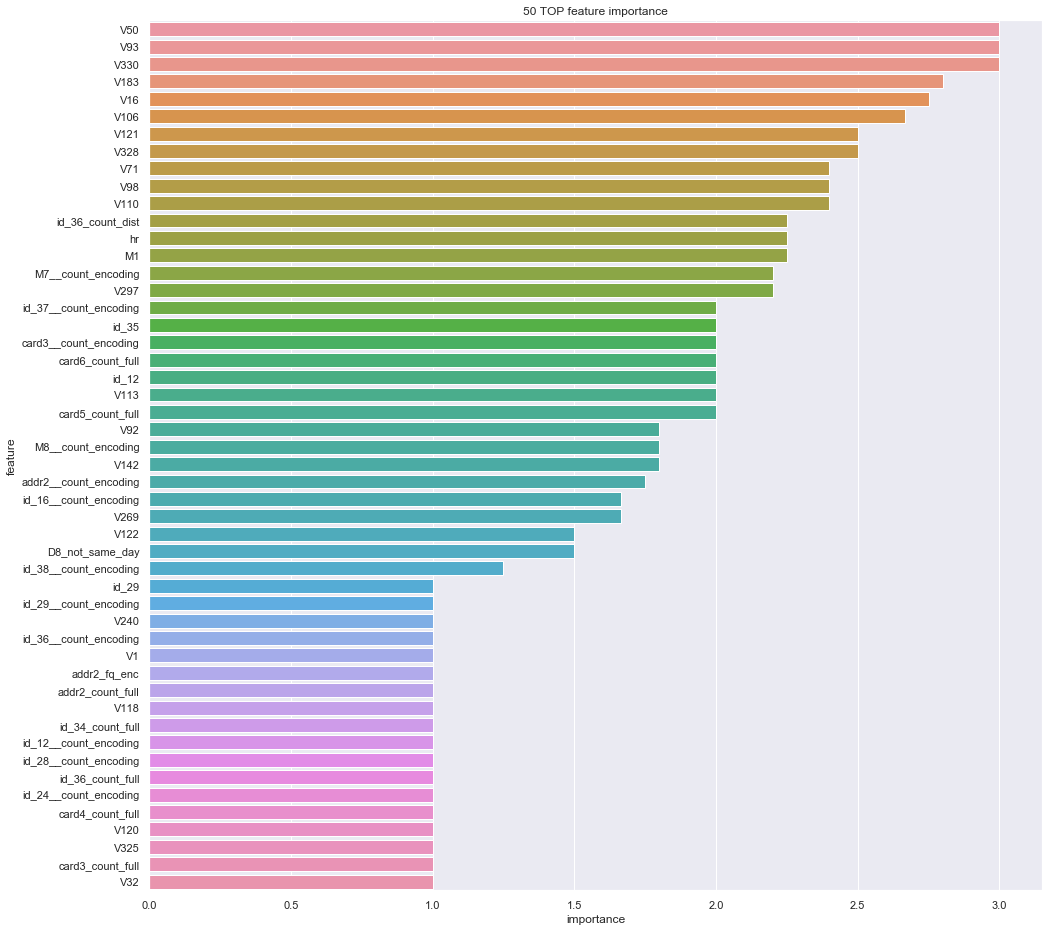

In [61]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='importance', ascending=False).tail(50), x='importance', y='feature');
plt.title('50 tail feature importance');

In [54]:
sub = pd.read_csv('sample_submission.csv')

In [55]:
sub['isFraud'] = y_preds
sub.to_csv("xgb_final4.csv", index=False) #0.9460

In [64]:
feature_importances['perc']=feature_importances['importance']/np.sum(feature_importances['importance'])

In [65]:
feature_importances['cum_sum'] = feature_importances['importance'].cumsum()
feature_importances['cum_perc'] = 100*feature_importances['cum_sum']/feature_importances['importance'].sum()

In [66]:
feature_importances['cum_perc']

0        0.517041
1        0.640891
2        0.668863
3        0.965823
4        1.091609
5        1.195052
6        1.218802
7        1.749565
8        1.950118
9        2.159468
10       2.342604
11       2.621972
12       2.979977
13       3.092745
14       3.123531
15       3.127050
16       3.197595
17       3.209910
18       3.284502
19       3.304029
20       3.548564
21       3.696516
22       3.726951
23       3.736626
24       3.893375
25       3.929439
26       4.099206
27       4.158492
28       4.313833
29       4.413934
          ...    
884     94.604410
885     94.829241
886     95.035072
887     95.266764
888     95.383929
889     95.500039
890     95.627408
891     95.741935
892     95.937914
893     96.171541
894     96.377900
895     96.605546
896     96.742415
897     96.882274
898     97.110448
899     97.363602
900     97.605146
901     97.811153
902     98.069762
903     98.391702
904     98.708366
905     98.869864
906     99.195851
907     99.519200
908     99

In [78]:
selected_feature=feature_importances[feature_importances['cum_perc']<=95]['feature']

In [79]:
len(selected_feature)

886

In [80]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [81]:
X2=X[selected_feature]

In [82]:
X2.shape

(590540, 886)

In [83]:
X_test2=X_test[selected_feature]

In [84]:
X_test2.shape

(506691, 886)

In [85]:
columns = X2.columns
splits = folds.split(X2, y, groups=split_groups)
y_preds = np.zeros(X_test2.shape[0])
y_oof = np.zeros(X2.shape[0])
score = 0

feature_importance_df = pd.DataFrame()
dtest = xgb.DMatrix(X_test2)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    dtrain = xgb.DMatrix(X2[columns].iloc[train_index], y.iloc[train_index])
    dvalid = xgb.DMatrix(X2[columns].iloc[valid_index], y.iloc[valid_index])
    y_valid= y.iloc[valid_index]
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'nthread' : 4,
              'eta' : 0.048,
              'max_depth' : 9,
              'missing': -999,
              #'tree_method':'gpu_hist',
              'subsample' : 0.85,
              'colsample_bytree' : 0.85,
              'alpha' : 0.15,
              'lambda' : 0.85,
              'random_state': 99, 
              'silent': True}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 200, verbose_eval=200)
    
    y_pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / NFOLDS
    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(list(model.get_fscore().keys()), columns=['feature'])
    fold_importance_df['importance']=list(model.get_fscore().values())
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del model, dtrain, dvalid, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

[0]	train-auc:0.844372	valid-auc:0.801597
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.992327	valid-auc:0.906303
[400]	train-auc:0.998658	valid-auc:0.911183
Stopping. Best iteration:
[389]	train-auc:0.998533	valid-auc:0.911767

Fold 1 | AUC: 0.9117674423844575
[0]	train-auc:0.821665	valid-auc:0.804041
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.991773	valid-auc:0.93753
[400]	train-auc:0.998392	valid-auc:0.940855
[600]	train-auc:0.99972	valid-auc:0.940776
Stopping. Best iteration:
[432]	train-auc:0.998796	valid-auc:0.941229

Fold 2 | AUC: 0.941228729677884
[0]	train-auc:0.813133	valid-auc:0.81365
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.

In [86]:
sub['isFraud'] = y_preds
sub.to_csv("xgb_final4_re.csv", index=False) #0.9456, no need to remove

In [87]:
del X2, X_test2
gc.collect()

40

In [ ]:
# bayes

In [113]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
splits = folds.split(X, y, groups=split_groups)

In [114]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    train_index_df=pd.DataFrame(train_index,columns=['train_index'])
    valid_index_df=pd.DataFrame(valid_index,columns=['valid_index'])
    del train_index, valid_index
    gc.collect()

In [115]:
train_index_df.shape

(420864, 1)

In [116]:
valid_index_df.shape

(169676, 1)

In [117]:
from bayes_opt import BayesianOptimization

In [118]:
train_index=train_index_df['train_index']
valid_index=valid_index_df['valid_index']

In [119]:
X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

In [120]:
X_train.shape

(420864, 949)

In [121]:
X_valid.shape

(169676, 949)

In [122]:
y_train.shape

(420864,)

In [123]:
y_valid.shape

(169676,)

In [124]:
def XGB_bayesian(
    gamma,
    max_leaves, 
    subsample,
    colsample_bytree,
    min_child_weight,
    max_depth,
    alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    max_leaves = int(max_leaves)
    max_depth = int(max_depth)

    assert type(max_leaves) == int
    assert type(max_depth) == int
    y_oof = np.zeros(X_valid.shape[0])

    param = { 'gamma':gamma,
              'max_leaves': max_leaves, 
              'min_child_weight': min_child_weight,
              'subsample' : subsample,
              'colsample_bytree' : colsample_bytree,
              'max_depth': max_depth,
              'alpha': alpha,
              'reg_lambda': reg_lambda,
              'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'missing': -999,
              'nthread' : 4,
              'eta' : 0.048,
              'random_state': 99, 
              'silent': True}    
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(param, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 200, verbose_eval=200)
    
    y_oof = model.predict(dvalid, ntree_limit=model.best_ntree_limit)

    score = roc_auc_score(y_valid, y_oof)

    return score

In [125]:
bounds_XGB = {
    'gamma': (0,1),
    'max_leaves': (100, 600), 
    'subsample' : (0.2,0.9),
    'colsample_bytree' : (0.2,0.9),
    'min_child_weight': (0.01, 0.1),   
    'alpha': (0.3, 1), 
    'reg_lambda': (0.3, 1),
    'max_depth':(0,15),
}

In [126]:
XGB_BO = BayesianOptimization(XGB_bayesian, bounds_XGB)

In [127]:
print(XGB_BO.space.keys)

['alpha', 'colsample_bytree', 'gamma', 'max_depth', 'max_leaves', 'min_child_weight', 'reg_lambda', 'subsample']


In [128]:
init_points = 3
n_iter = 7

In [129]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   |   alpha   | colsam... |   gamma   | max_depth | max_le... | min_ch... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	train-auc:0.772413	valid-auc:0.766697
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.955875	valid-auc:0.925515
[400]	train-auc:0.976196	valid-auc:0.935802
[600]	train-auc:0.986441	valid-auc:0.939487
[800]	train-auc:0.992484	valid-auc:0.94113
[1000]	train-auc:0.996061	valid-auc:0.94264
[1200]	train-auc:0.997878	valid-auc:0.943426
[1400]	train-auc:0.998917	valid-auc:0.943348
Stopping. Best iteration:
[1272]	train-auc:0.998332	valid-auc:0.943895

|  1        |  0.9439   |  0.3204   |  0.4749   |  0.3983 

In [130]:
params = {'max_leaves': int(XGB_BO.max['params']['max_leaves']),
          'min_child_weight': XGB_BO.max['params']['min_child_weight'],
          'subsample': XGB_BO.max['params']['subsample'],
          'colsample_bytree': XGB_BO.max['params']['colsample_bytree'],
          'max_depth': int(XGB_BO.max['params']['max_depth']),
          'alpha': XGB_BO.max['params']['alpha'],
          'reg_lambda':XGB_BO.max['params']['reg_lambda'],
          'eval_metric': 'auc',
          'objective': 'binary:logistic',
          'booster':'gbtree',
          'missing': -999,
          'nthread' : 4,
          'eta' : 0.048,
          'random_state': 99, 
          'silent': True
         }

In [131]:
params # copy this one 

{'max_leaves': 525,
 'min_child_weight': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.9,
 'max_depth': 15,
 'alpha': 0.3,
 'reg_lambda': 1.0,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'missing': -999,
 'nthread': 4,
 'eta': 0.048,
 'random_state': 99,
 'silent': True}

In [132]:
columns = X.columns
splits = folds.split(X, y, groups=split_groups)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importance_df = pd.DataFrame()
dtest = xgb.DMatrix(X_test)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    dtrain = xgb.DMatrix(X[columns].iloc[train_index], y.iloc[train_index])
    dvalid = xgb.DMatrix(X[columns].iloc[valid_index], y.iloc[valid_index])
    y_valid= y.iloc[valid_index]
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 200, verbose_eval=200)
    
    y_pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / NFOLDS
    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(list(model.get_fscore().keys()), columns=['feature'])
    fold_importance_df['importance']=list(model.get_fscore().values())
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del model, dtrain, dvalid, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

[0]	train-auc:0.868421	valid-auc:0.807226
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:1	valid-auc:0.896425
[400]	train-auc:1	valid-auc:0.910273
[600]	train-auc:1	valid-auc:0.911607
Stopping. Best iteration:
[531]	train-auc:1	valid-auc:0.911911

Fold 1 | AUC: 0.9119105385164745
[0]	train-auc:0.867274	valid-auc:0.841862
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:1	valid-auc:0.942429
[400]	train-auc:1	valid-auc:0.944673
[600]	train-auc:1	valid-auc:0.944965
Stopping. Best iteration:
[465]	train-auc:1	valid-auc:0.945153

Fold 2 | AUC: 0.945153042487195
[0]	train-auc:0.869037	valid-auc:0.842658
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:1	valid-auc

In [134]:
sub['isFraud'] = y_preds
sub.to_csv("xgb_final4_baye.csv", index=False) #0.9471

In [137]:
feature_importances = feature_importance_df.groupby('feature').agg({'importance':np.mean}).reset_index()

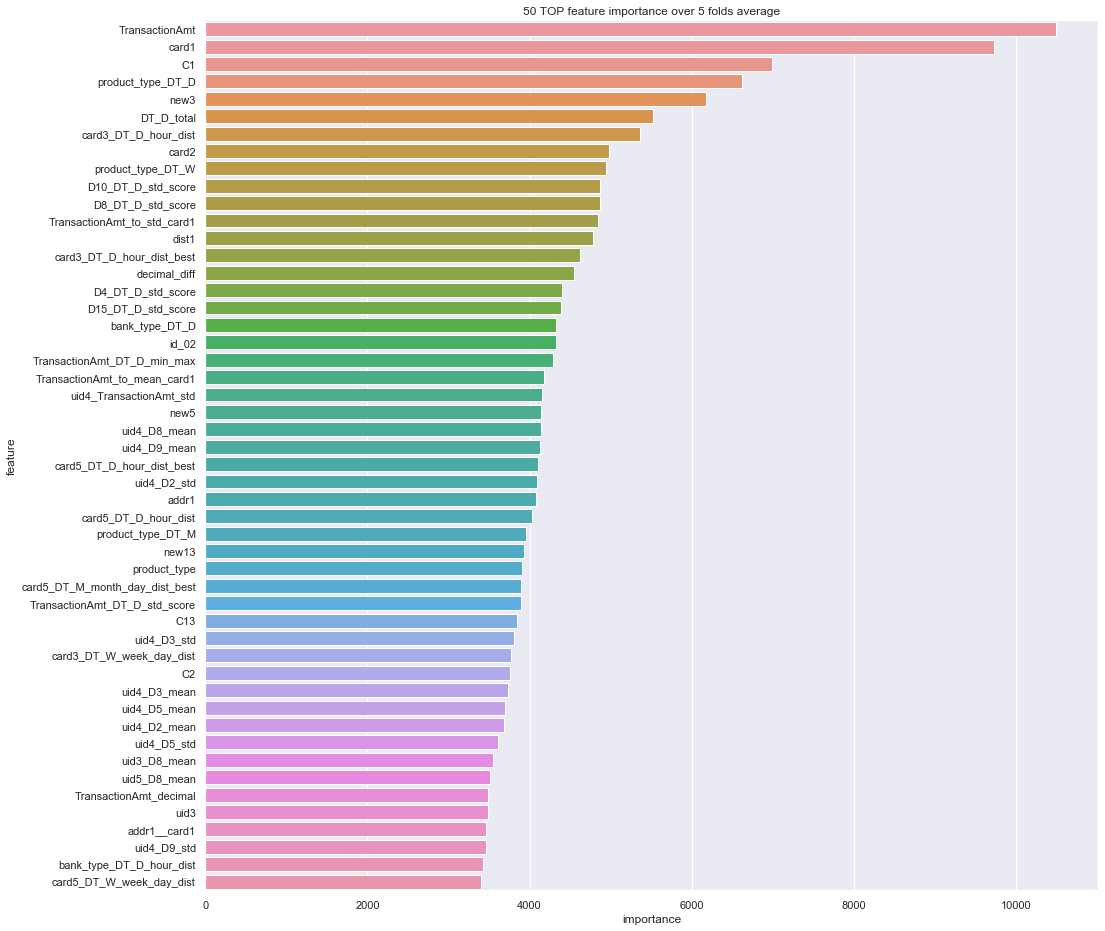

In [138]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='importance', ascending=False).head(50), x='importance', y='feature');
plt.title('50 TOP feature importance over 5 folds average');

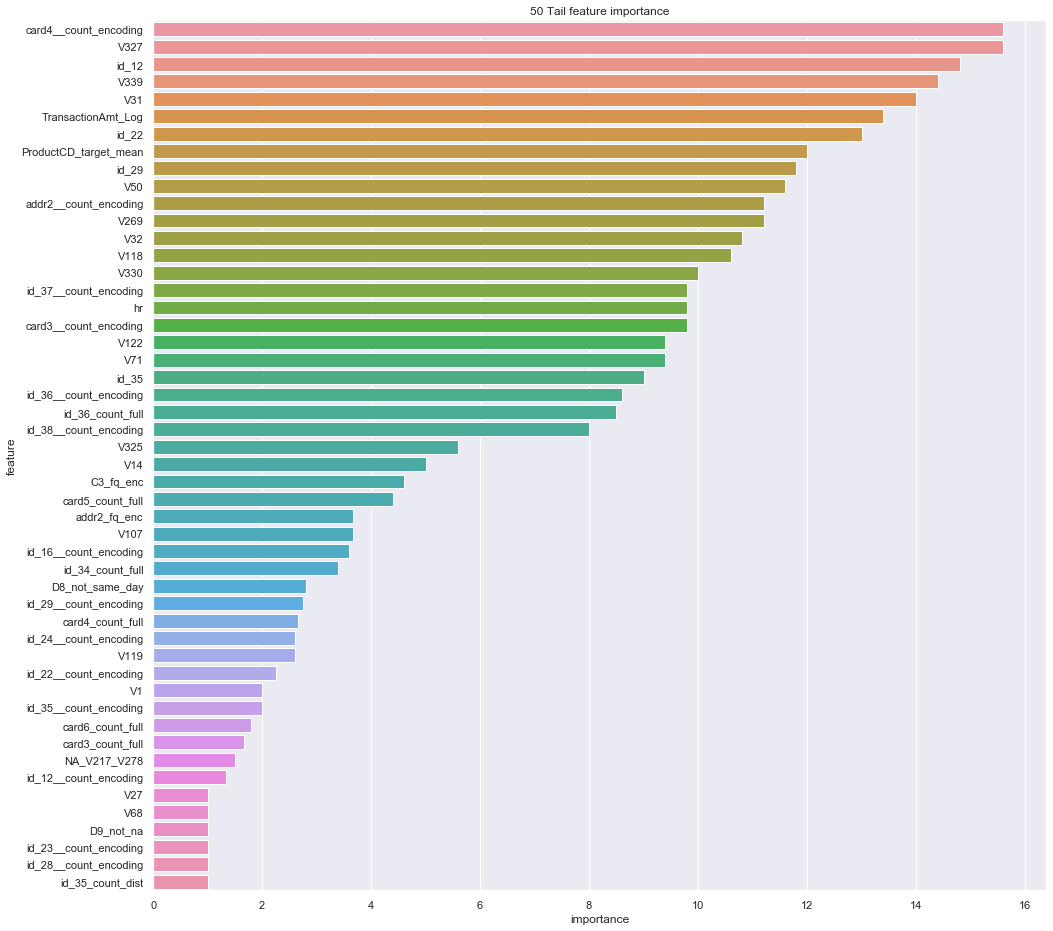

In [139]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='importance', ascending=False).tail(50), x='importance', y='feature');
plt.title('50 Tail feature importance');

In [140]:
feature_importances['cum_sum'] = feature_importances['importance'].cumsum()
feature_importances['cum_perc'] = 100*feature_importances['cum_sum']/feature_importances['importance'].sum()

In [141]:
selected_feature=feature_importances[feature_importances['cum_perc']<=95]['feature']

In [142]:
len(selected_feature)

896

In [143]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [144]:
X2=X[selected_feature]

In [145]:
X2.shape

(590540, 896)

In [146]:
X_test2=X_test[selected_feature]

In [147]:
X_test2.shape

(506691, 896)

In [148]:
params = {'max_leaves': int(XGB_BO.max['params']['max_leaves']),
          'min_child_weight': XGB_BO.max['params']['min_child_weight'],
          'subsample': XGB_BO.max['params']['subsample'],
          'colsample_bytree': XGB_BO.max['params']['colsample_bytree'],
          'max_depth': int(XGB_BO.max['params']['max_depth']),
          'alpha': XGB_BO.max['params']['alpha'],
          'reg_lambda':XGB_BO.max['params']['reg_lambda'],
          'eval_metric': 'auc',
          'objective': 'binary:logistic',
          'booster':'gbtree',
          'missing': -999,
          'nthread' : 4,
          'eta' : 0.048,
          'random_state': 99, 
          'silent': True
         }

In [149]:
columns = X2.columns
splits = folds.split(X2, y, groups=split_groups)
y_preds = np.zeros(X_test2.shape[0])
y_oof = np.zeros(X2.shape[0])
score = 0

feature_importance_df = pd.DataFrame()
dtest = xgb.DMatrix(X_test2)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    dtrain = xgb.DMatrix(X2[columns].iloc[train_index], y.iloc[train_index])
    dvalid = xgb.DMatrix(X2[columns].iloc[valid_index], y.iloc[valid_index])
    y_valid= y.iloc[valid_index]
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'nthread' : 4,
              'eta' : 0.048,
              'max_depth' : 9,
              'missing': -999,
              #'tree_method':'gpu_hist',
              'subsample' : 0.85,
              'colsample_bytree' : 0.85,
              'alpha' : 0.15,
              'lambda' : 0.85,
              'random_state': 99, 
              'silent': True}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 200, verbose_eval=200)
    
    y_pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / NFOLDS
    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(list(model.get_fscore().keys()), columns=['feature'])
    fold_importance_df['importance']=list(model.get_fscore().values())
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del model, dtrain, dvalid, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

[0]	train-auc:0.824339	valid-auc:0.80318
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.992116	valid-auc:0.905107
[400]	train-auc:0.998559	valid-auc:0.911248
[600]	train-auc:0.999765	valid-auc:0.910881
Stopping. Best iteration:
[511]	train-auc:0.999452	valid-auc:0.912522

Fold 1 | AUC: 0.9125215869752606
[0]	train-auc:0.824338	valid-auc:0.805999
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.991753	valid-auc:0.939523
[400]	train-auc:0.998464	valid-auc:0.941603
Stopping. Best iteration:
[336]	train-auc:0.997279	valid-auc:0.942168

Fold 2 | AUC: 0.9421680752199951
[0]	train-auc:0.845365	valid-auc:0.834777
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc

In [150]:
sub['isFraud'] = y_preds
sub.to_csv("xgb_final4_baye_re.csv", index=False) #0.9461 no need to remove